
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Processor Demo

This notebook provides an introduction to the signal `Processor()` object. The main object type in the DDSP library, it is the base class is used for Synthesizers and Effects, which share the methods:

* `get_controls()`: inputs -> controls.
* `get_signal()`: controls -> signal.
* `__call__()`: inputs -> signal. (i.e. `get_signal(**get_controls())`)

Where:
* `inputs` is a variable number of tensor arguments (depending on processor). Often the outputs of a neural network.
* `controls` is a dictionary of tensors scaled and constrained specifically for the processor
* `signal` is an output tensor (usually audio or control signal for another processor)

Let's see why this is a helpful approach by looking at the specific example of the `Additive()` synthesizer processor. 

In [0]:
# Imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from colabtools import sound
import ddsp 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

# Helper Functions.
sess = tf.compat.v1.InteractiveSession()
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)

def f32(tensor):
  return tf.convert_to_tensor(tensor, dtype=tf.float32)

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  logmag = ddsp.spectral_ops.calc_logmag(f32(audio), size=size).eval()
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])

# Example: additive synthesizer

The additive synthesizer models a sound as a linear combination of harmonic sinusoids. Amplitude envelopes are generated with 50% overlapping hann windows. The final audio is cropped to n_samples.

## `__init__()`

All member variables are initialized in the constructor, which makes it easy to change them as hyperparameters using the [gin](https://github.com/google/gin-config) dependency injection library. All processors also have a `name` that is used by `ProcessorGroup()`.

In [0]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Create a synthesizer object.
additive_synth = ddsp.synths.Additive(n_samples=n_samples,
                                      sample_rate=sample_rate,
                                      name='additive_synth')


## `get_controls()` 

The outputs of a neural network are often not properly scaled and constrained Gives a dictionary of valid control parameters from neural network outputs.



### 3 inputs (amps, hd, f0)
* `amplitude`: Amplitude envelope of the synthesizer output.
* `harmonic_distribution`: Normalized amplitudes of each harmonic.
* `fundamental_frequency`: Frequency in Hz of base oscillator



In [0]:
# Generate some arbitrary inputs.

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1])

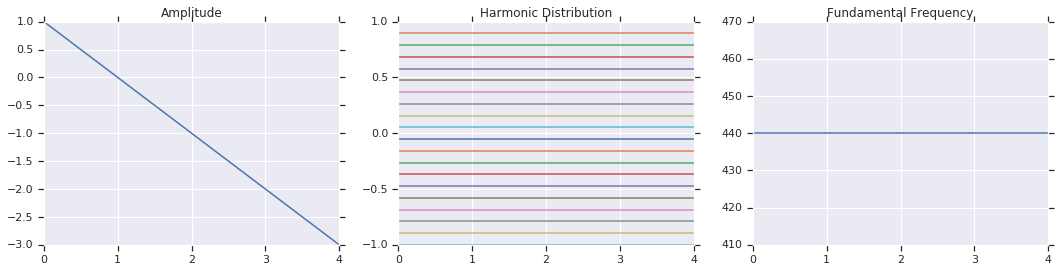

In [0]:
# Plot it!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, amps[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, harmonic_distribution[0, :, :])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, f0_hz[0, :, 0])
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

Consider the plots above as outputs of a neural network. These outputs violate the synthesizer's expectations:
* Amplitude is not >= 0 (avoids phase shifts)
* Harmonic distribution is not normalized (factorizes timbre and amplitude)
* Fundamental frequency * n_harmonics > nyquist frequency (440 * 20 > 8000), which will lead to [aliasing](https://en.wikipedia.org/wiki/Aliasing).


In [0]:
controls = additive_synth.get_controls(f32(amps), 
                                       f32(harmonic_distribution), 
                                       f32(f0_hz))
print(controls.keys())

['harmonic_distribution', 'f0_hz', 'amplitudes']


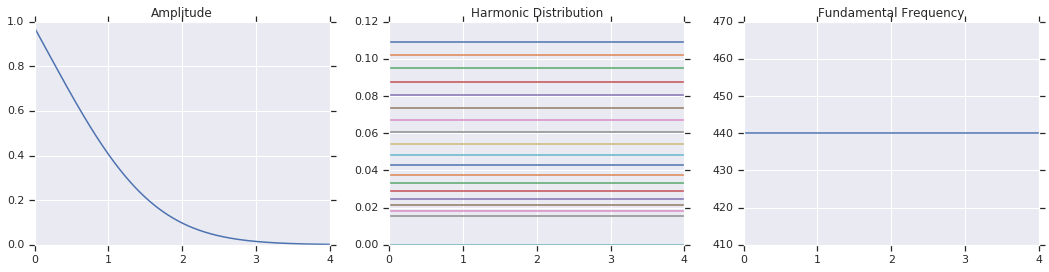

In [0]:
# Now let's see what they look like...
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

Notice that 
* Amplitudes are now all positive
* The harmonic distribution sums to 1.0
* All harmonics that are above the Nyquist frequency now have an amplitude of 0.

### ...`ddsp.core.exp_sigmoid()`

The amplitudes and harmonic distribution are scaled by an "exponentiated sigmoid" function (`ddsp.core.exp_sigmoid`). There is nothing particularly special about this function (other functions can be specified as `amp_scale_fn=` during construction), but it has several nice properties:
* Output scales logarithmically with input (as does human perception of loudness)
* Centered at 0, with max and min in reasonable range for normalized neural network outputs.
* Max value of 2.0 to prevent signal getting too loud.
* Threshold value of 1e-7 for numerical stability during training.

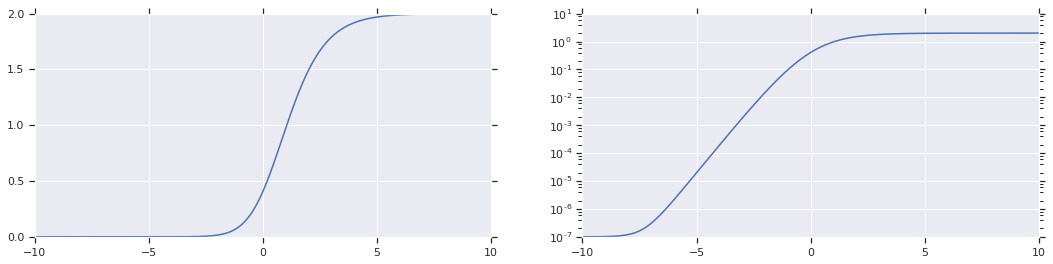

In [0]:
x = tf.linspace(-10.0, 10.0, 1000)
y = ddsp.core.exp_sigmoid(x)

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(x.eval(), y.eval())

plt.subplot(122)
plt.semilogy(x.eval(), y.eval())

## `get_signal()`

Synthesize audio from controls

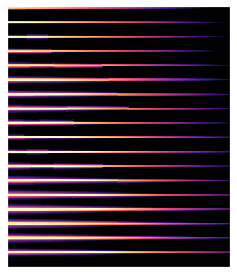

In [0]:
audio = additive_synth.get_signal(**controls)
audio_np = audio.eval()[0, :]

play(audio_np)
specplot(audio_np)

## `__call__()` 

Synthesize audio from inputs

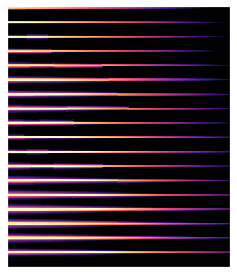

In [0]:
audio = additive_synth(f32(amps), 
                       f32(harmonic_distribution), 
                       f32(f0_hz))
audio_np = audio.eval()[0, :]

play(audio_np)
specplot(audio_np)

# Example: Just for fun... 
Let's run another example where we tweak some of the controls...

In [0]:
## Some weird control envelopes...

# Amplitude [batch, n_frames, 1].
amps = np.ones([n_frames]) * -5.0
amps[:50] +=  np.linspace(0, 7.0, 50)
amps[50:200] += 7.0
amps[200:900] += (7.0 - np.linspace(0.0, 7.0, 700))
amps *= np.abs(np.cos(np.linspace(0, 2*np.pi * 10.0, n_frames)))
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
for i in range(n_harmonics):
  harmonic_distribution[:, i] = 1.0 - np.linspace(i * 0.09, 2.0, 1000)
  harmonic_distribution[:, i] *= 5.0 * np.abs(np.cos(np.linspace(0, 2*np.pi * 0.1 * i, n_frames)))
  if i % 2 != 0:
    harmonic_distribution[:, i] = -3
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = np.ones([n_frames]) * 200.0
f0_hz[:100] *= np.linspace(2, 1, 100)**2
f0_hz[200:1000] += 20 * np.sin(np.linspace(0, 8.0, 800) * 2 * np.pi * np.linspace(0, 1.0, 800))  * np.linspace(0, 1.0, 800)
f0_hz = f0_hz[np.newaxis, :, np.newaxis]

# Get valid controls
controls = additive_synth.get_controls(f32(amps), f32(harmonic_distribution), f32(f0_hz))

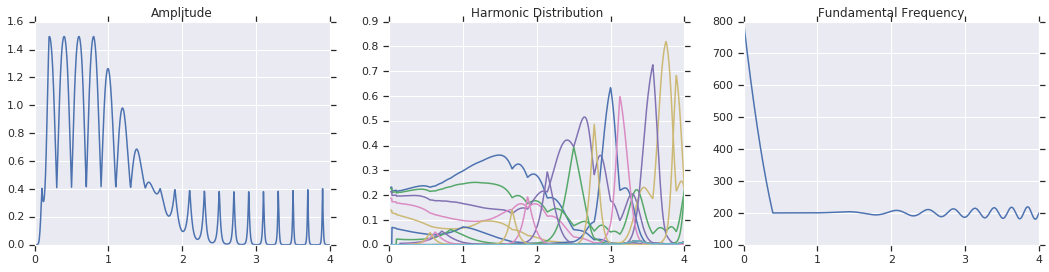

In [0]:
# Plot!
time = np.linspace(0, n_samples / sample_rate, n_frames)

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(time, controls['amplitudes'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Amplitude')

plt.subplot(132)
plt.plot(time, controls['harmonic_distribution'][0, :, :].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Harmonic Distribution')

plt.subplot(133)
plt.plot(time, controls['f0_hz'][0, :, 0].eval())
plt.xticks([0, 1, 2, 3, 4])
plt.title('Fundamental Frequency')

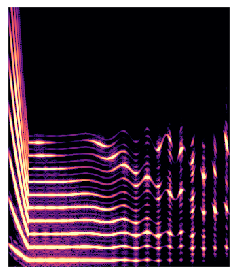

In [0]:
audio = additive_synth.get_signal(**controls)
audio_np = audio.eval()[0, :]

play(audio_np)
specplot(audio_np)